# Calculating contributing geologic units to Mataquito River

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors
import rasterio
from rasterio.plot import show
from pyproj import Proj, transform

In [9]:
# import excel file
excel_path = "/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Geology/subwatershed_geologic_units_data.xlsx"
xls = pd.ExcelFile(excel_path)

# get sheet names
sheet_names = xls.sheet_names

In [8]:
# Create pie charts
def create_pie_charts(summaries):
    """Create pie charts for each subwatershed"""
    print(f"\nCreating pie charts for {len(summaries)} subwatersheds...")
    
    # Get all unique GEO units across all subwatersheds
    all_geo_units = set()
    for data in summaries.values():
        all_geo_units.update(data['GEO'].values)
    all_geo_units = sorted(list(all_geo_units))
    
    # Create consistent color mapping for each GEO unit using multiple color palettes
    # Combine multiple color palettes to get more distinct colors
    colors1 = plt.cm.Set3(np.linspace(0, 1, 12))
    colors2 = plt.cm.Pastel1(np.linspace(0, 1, 9))
    colors3 = plt.cm.Dark2(np.linspace(0, 1, 8))
    colors4 = plt.cm.Accent(np.linspace(0, 1, 8))
    
    all_colors = np.concatenate([colors1, colors2, colors3, colors4])
    
    geo_color_map = {geo: all_colors[i % len(all_colors)] for i, geo in enumerate(all_geo_units)}
    
    # Calculate subplot layout
    n_subs = len(summaries)
    n_cols = 2 if n_subs > 1 else 1
    n_rows = (n_subs + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Handle single subplot case
    if n_subs == 1:
        axes = [axes]
    elif n_rows == 1 and n_cols > 1:
        axes = list(axes)
    elif n_rows > 1:
        axes = axes.flatten()
    
    # Create each pie chart
    for i, (subwatershed, data) in enumerate(summaries.items()):
        ax = axes[i]
        
        # Prepare labels, sizes, and colors for this subwatershed
        labels = []
        sizes = data['percent'].values
        chart_colors = []
        
        for _, row in data.iterrows():
            labels.append(f"{row['GEO']}")
            chart_colors.append(geo_color_map[row['GEO']])
        
        # Create pie chart
        ax.pie(sizes, labels=labels, colors=chart_colors, 
               startangle=90, textprops={'fontsize': 9})
        
        # Title
        ax.set_title(f"{subwatershed}\nTotal: {data['area_km2'].sum():.1f} km²", 
                    fontsize=12, fontweight='bold', pad=20)
        ax.axis('equal')
    
    # Hide unused subplots
    for i in range(len(summaries), len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()



Creating pie charts for 11 subwatersheds...


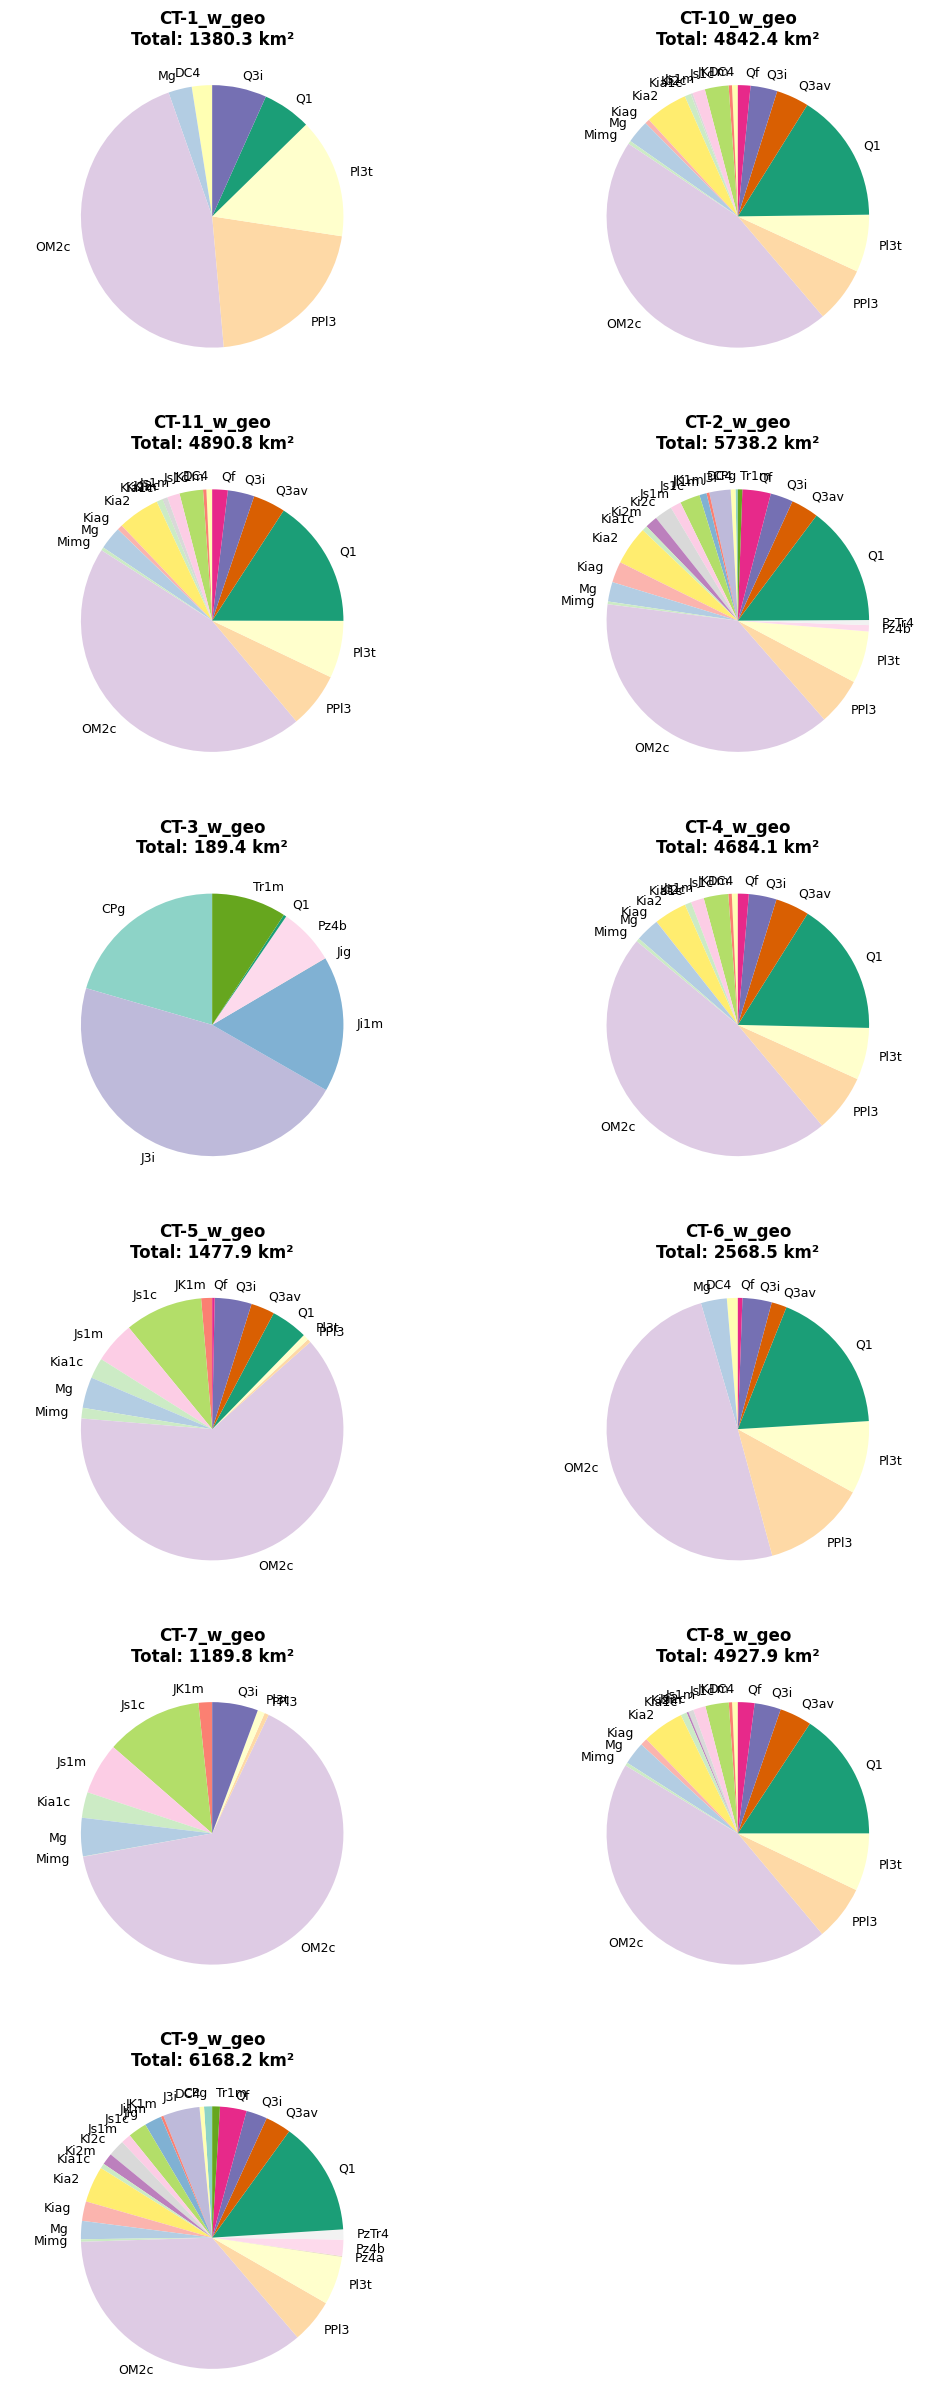

In [9]:
# Run the display and charts
create_pie_charts(summaries)

In [4]:
geologic_colors = {
    # SEDIMENTARY SEQUENCES (Column 1)
    # Quaternary
    'Qan': '#ffffc5',        # Holocene deposits
    'Q1': '#ffff6e',        # Pleistocene-Holocene alluvial/colluvial deposits
    'Qf': '#ffffe2',        # Pleistocene-Holocene fluvial deposits
    'Qm': '#f5ff6e',        # Pleistocene-Holocene coastal deposits
    'Qa': '#f5ffa8',        # Pleistocene-Holocene alluvial deposits
    'Q1g': '#f5ff00',       # Pleistocene-Holocene morainic/fluvioglacial
    'Q1g1': '#ffffc5',       # Pleistocene-Holocene morainic/fluvioglacial
    'Q1g2': '#ffff51',
    'Q1g3': '#faff51',
    'Q1g4': '#f0ff6e',
    'Qe': '#ffff8b',        # Pleistocene-Holocene eolian deposits
    
    # Neogene
    'PPl1m': '#faff6e',
    'Pl1m': '#ffff34',      # Pleistocene marine sequences
    'PPl1r': '#fac56e',     # Pliocene-Pleistocene mass removal deposits
    'PPl1c': '#ffff17',     # Pliocene-Pleistocene conglomerates/sandstones
    'PPl1l': '#faff51',     # Pliocene-Pleistocene lacustrine sequences
    'MQs': '#d8feff',       # Miocene-Quaternary evaporites
    'MP1m': '#ffe2e2',      # Upper Miocene-Pliocene marine sequences
    'MP1c': '#fac58b',      # Upper Miocene-Pliocene clastic sequences
    'MP1l': '#faa88b',      # Upper Miocene-Pliocene lacustrine sequences
    'M1c': '#fae28b',       # Lower-Middle Miocene alluvial fan sequences
    'M1m': '#fa8bc5',       # Miocene marine sequences
    'OM1m': '#ffc517',      # Oligocene-Miocene marine sequences
    'OM1c': '#ffa86e',      # Oligocene-Miocene continental sequences
    'EM1m': '#e2c58b',      # Eocene-Miocene marine sequences
    
    # Paleogene
    'EO1c': '#e28b34',      # Eocene-Oligocene continental sequences
    'E1c': '#faa86e',       # Eocene continental sequences
    'E1m': '#fae200',       # Eocene marine sequences
    'PE1c': '#b78b51',      # Paleocene-Lower Eocene continental sequences
    'PE1': '#c1955b',       # Paleocene-Eocene marine/transitional sequences
    'Pa1m': '#ffff51',      # Paleocene marine sequences
    
    # Cretaceous-Tertiary
    'KT1c': '#e2c56e',      # Upper Cretaceous-Lower Tertiary continental
    
    # Cretaceous
    'Ks1m': '#17ff6e',      # Upper Cretaceous marine sequences
    'Ks1mp': '#cee251',     # Campanian-Maastrichtian marine/paralic
    'Ks1c': '#b7ff8b',      # Upper Cretaceous continental sequences
    'Kia1c': '#17ffa8',     # Upper Lower Cretaceous continental sequences
    'Ki1m': '#6ec517',      # Lower Cretaceous marine sequences
    
    # Jurassic-Cretaceous
    'JK1m': '#85a800',      # Upper Jurassic-Lower Cretaceous marine
    'JK1c': '#8bffc5',      # Upper Jurassic-Lower Cretaceous continental
    'JK1': '#17ffc5',       # Upper Jurassic-Lower Cretaceous transitional
    
    # Jurassic
    'J1m': '#ebffff',       # Jurassic-Neocomian marine sequences
    'Js1c': '#b7e2ff',      # Upper Jurassic continental sequences
    'Js1m': '#17a8ff',      # Middle-Upper Jurassic marine sequences
    'Ji1m': '#ceffff',      # Lower-Middle Jurassic marine sequences
    
    # Triassic-Jurassic
    'TrJ1m': '#a5f5fe',     # Triassic-Lower Jurassic marine sequences
    'TrJ1c': '#6eedc3',     # Triassic-Lower Jurassic continental sequences
    
    # Triassic
    'Tr1c': '#cee2c5',      # Upper Triassic continental sequences
    'Tr1m': '#cee2ff',      # Upper Triassic marine sequences
    
    # Permian
    'P1m': '#aa826e',       # Permian turbidites
    
    # Carboniferous-Permian
    'CP1': '#ffdfff',       # Upper Carboniferous-Permian sequences
    
    # Devonian-Triassic
    'DTr1c': '#e1e173',     # Devonian-Triassic continental sequences
    
    # Devonian-Carboniferous
    'DC1': '#b76e00',       # Devonian-Carboniferous marine sequences
    
    # Ordovician-Silurian
    'OS1m': '#9b9b9b',      # Ordovician-Silurian marine sequences
    
    # Cambrian-Ordovician
    'CaO1m': '#3939ff',     # Cambrian-Ordovician marine sequences
    
    # Cambrian-Devonian
    'CaD1': '#efefff',      # Middle Cambrian-Devonian sequences
    
    # Cambrian
    'Ca1': '#5858ff',       # Cambrian sequences
    
    # VOLCANOSEDIMENTARY SEQUENCES (Column 2)
    # Neogene
    'MP2': '#f5a8a8',       # Upper Miocene-Pliocene volcanosedimentary
    'M2c': '#ffa817',       # Lower-Middle Miocene volcanosedimentary
    'OM2m': '#fac534',      # Oligocene-Miocene marine volcanosedimentary
    'OM2c': '#f0ffa8',      # Oligocene-Miocene volcanosedimentary
    
    # Paleogene
    'EO2c': '#c56e00',      # Eocene-Oligocene volcanosedimentary
    'E2c': '#a86e6e',       # Eocene volcanosedimentary
    
    # Cretaceous-Tertiary
    'KT2': '#a8ff8b',       # Upper Cretaceous-Lower Tertiary volcanosedimentary
    'KE2': '#a8ff64',       # Cretaceous-Eocene volcanosedimentary
    
    # Cretaceous
    'Ks2c': '#6eff6e',      # Upper Cretaceous continental volcanosedimentary
    'Ks2m': '#c1ff95',      # Upper Cretaceous marine volcanoclastic
    'Kia2': '#cee26e',      # Upper Lower-Lower Upper Cretaceous sequences
    'Ki2c': '#81ff81',      # Lower-Upper Cretaceous continental sequences
    'Ki2m': '#8ba86e',      # Lower Cretaceous marine volcanic/sedimentary
    
    # Jurassic
    'J2m': '#c5ffff',       # Jurassic marine volcanic/sedimentary
    'Js2c': '#0ecdff',      # Middle-Upper Jurassic continental sequences
    
    # Triassic-Cretaceous
    'TrK2': '#8b51e2',      # Triassic-Cretaceous turbidites/basalts
    
    # Triassic
    'Tr2c': '#c5e2c5',      # Middle-Upper Triassic continental sequences
    
    # Carboniferous-Permian
    'CP2m': '#b7e2a8',      # Carboniferous-Permian marine volcanosedimentary
    'CP2': '#b7e2c5',       # Carboniferous-Permian continental sequences
    
    # VOLCANIC SEQUENCES (Column 3)
    # Quaternary
    'Q3i': '#e26eff',       # Quaternary stratovolcanoes/volcanic complexes
    'Q3t': 'fad8ec',       # Quaternary pyroclastic flow deposits
    'Q3av': '#fae2c5',      # Quaternary volcanic avalanche deposits
    
    # Neogene
    'Pl3': '#e9e9ff',       # Pleistocene lava sequences/volcanic centers
    'Pl3t': '#fae2e2',      # Pleistocene pyroclastic deposits
    'PPl3': '#ffe9e9',      # Pliocene-Pleistocene volcanic sequences
    'P3t': '#ffc513',       # Pliocene pyroclastic deposits
    'P3i': '#ffc5ff',       # Pliocene volcanic centers
    'MP3': '#ffc58b',       # Miocene-Pliocene plateau basalts
    'Ms3t': '#ffc534',      # Upper Miocene ignimbrites
    'Ms3i': '#fa8b6e',      # Upper Miocene volcanic centers/sequences
    'M3o': '#e25100',       # Miocene ophiolites
    'M3av': '#ce6eff',      # Lower-Middle Miocene volcanic avalanche
    'M3b': '#f5c5a8',       # Miocene basaltic lavas
    'M3t': '#ffa800',       # Lower-Middle Miocene pyroclastic sequences
    'M3i': '#ffe26e',       # Lower-Middle Miocene volcanic complexes
    'OM3t': '#ff8bff',      # Oligocene-Miocene pyroclastic sequences
    'OM3': '#ffa8ff',       # Oligocene-Miocene volcanic sequences/centers
    'OM3b': '#ffe2c5',      # Oligocene-Miocene basic volcanic sequences
    
    # Paleogene
    'E3b': '#c56e17',       # Eocene plateau basalts
    'E3': '#8b5117',        # Eocene volcanic sequences/centers
    'PE3a': '#d85134',      # Paleocene-Lower Eocene acidic volcanic sequences
    'PE3i': '#f56e6e',      # Paleocene-Lower Eocene intermediate volcanic
    
    # Cretaceous
    'Ks3a': '#b7ff51',      # Upper Cretaceous acidic volcanic sequences
    'Ks3i': '#b7ff6e',      # Upper Cretaceous intermediate volcanic sequences
    'Kia3': '#6effa8',      # Upper Lower Cretaceous volcanic sequences
    
    # Jurassic-Tertiary
    'JT3': '#00abab',       # Jurassic-Tertiary basalts/andesites/rhyolites
    
    # Jurassic-Cretaceous
    'JK3o': '#8bffe2',      # Jurassic-Cretaceous ophiolitic complexes
    'JK3': '#17e2e2',       # Upper Jurassic-Lower Cretaceous volcanic
    
    # Jurassic
    'J3a': '#b7cde2',       # Jurassic acidic volcanic sequences
    'J3i': '#c5e2ff',       # Jurassic intermediate volcanic sequences
    
    # Triassic-Jurassic
    'TrJ3': '#cdf5fe',      # Triassic-Lower Jurassic volcanic sequences
    
    # Permian-Triassic
    'PTr3': '#a8a8a8',      # Permian-Triassic volcanic sequences
    
    # Carboniferous-Permian
    'CP3': '#a8e26e',       # Carboniferous-Permian volcanic sequences
    
    # Ordovician-Silurian
    'OS3': '#6e6e8b',       # Ordovician-Silurian volcanic sequences
    
    # INTRUSIVE ROCKS (Column g)
    # Neogene
    'Pg': '#ff3434',        # Pliocene granodiorites/tonalites/monzogranites
    'Msh': '#faa800',       # Upper Miocene porphyries (giant copper porphyry)
    'Msg': '#ff3451',       # Upper Miocene granodiorites
    'Mh': '#d8a800',        # Miocene porphyries
    'Mg': '#ff8ba8',        # Miocene granodiorites/diorites/tonalites
    'Mimg': '#fa51a8',      # Lower-Middle Miocene granodiorites/monzogranites
    
    # Paleogene
    'Og': '#fa8be2',        # Oligocene granodiorites/monzogranites/tonalites
    'EOp': '#f534c5',       # Eocene-Oligocene porphyries (giant copper porphyry)
    'Eg': '#ff51a8',        # Eocene granodiorites/tonalites
    'PEg': '#fa8bff',       # Paleocene-Eocene monzodiorites/granodiorites
    'Pag': '#ff3400',       # Paleocene monzodiorites/granodiorites
    
    # Cretaceous-Tertiary
    'KTg': '#ff6e34',       # Upper Cretaceous-Lower Tertiary granodiorites
    'KTg(a)': '#fa6ec5',
    
    # Cretaceous
    'Ksg': '#ff34e2',       # Upper Cretaceous monzodiorites/granodiorites
    'Ksh': '#ff8be2',       # Upper Cretaceous porphyries
    'Kiag': '#fa34c5',      # Upper Lower-Lower Upper Cretaceous diorites
    'Kibg': '#ff6ec5',      # Lower Lower Cretaceous monzodiorites/diorites
    'Kig': '#ff34a8',       # Lower Cretaceous granites/granodiorites
    
    # Jurassic-Cretaceous
    'JKg': '#ffa8e2',       # Jurassic-Cretaceous granodiorites/diorites
    
    # Jurassic
    'Jsg': '#faa8a8',       # Middle-Upper Jurassic monzodiorites/diorites
    'Jig': '#fa8b8b',       # Lower Jurassic diorites/gabros
    
    # Triassic-Jurassic
    'TrJg': '#f551e2',      # Triassic-Jurassic granodiorites/monzogranites
    
    # Triassic
    'Trg': '#eb34c5',       # Triassic leucocratic granites/monzogranites
    
    # Permian-Triassic
    'PTrg': '#ff6d6d',      # Permian-Triassic hololeucocratic granites
    
    # Carboniferous-Permian
    'CPg': '#ffe2ff',       # Carboniferous-Permian granites/granodiorites
    
    # Ordovician-Silurian
    'OSg': 'f58be2',       # Ordovician-Silurian leucocratic granites
    
    # METAMORPHIC ROCKS (Column 4)
    # Neogene
    'OM4': '#ffe2ff',       # Oligocene-Miocene metasediments/metabasites
    
    # Jurassic-Tertiary
    'JT4a': '#ceceb1',      # Jurassic-Tertiary low P/T gradient schists
    'JT4b': '#d8d8bb',      # Jurassic-Tertiary high P/T gradient schists
    
    # Jurassic
    'Js4': '#e2e2c5',       # Upper Jurassic high P/T gradient schists
    'Jsg4': '#17ff00',      # Upper Jurassic orthogneisses
    
    # Triassic
    'Tr4a': '#c58bc5',      # Triassic low grade metaturbidites
    'Tr4b': '#e28bc5',      # Triassic micaceous schists/phyllites
    
    # Permian-Cretaceous
    'PK4': '#f0e1af',       # Permian-Cretaceous gneisses/metabasites
    
    # Permian-Triassic
    'PTr4': '#f0e2c5',      # Permian-Triassic low grade metaturbidites
    'PzTr4': '#f0e2c5',     # Paleozoic-Triassic metapelites/metacherts
    'PzTr4(a)': '#f7f7f7',
    'PzTr4(b)': '#fcfcfc',
    
    # Devonian-Carboniferous
    'DC4': '#f0e2e2',       # Devonian-Carboniferous metasandstones/phyllites
    
    # Silurian-Carboniferous
    'Pz4a': '#f2f2f2',      # Silurian-Carboniferous high P/T schists (Western)
    'Pz4b': '#eaeaea',      # Silurian-Carboniferous low P/T schists (Eastern)
    
    # Precambrian-Permian
    'pCP4': '#ceceaa',      # Precambrian-Permian micaceous schists/metabasites
    
    # Precambrian-Ordovician
    'pCO4': '#d6d6d6',      # Precambrian-Ordovician micaceous schists/gneisses
    
    # SPECIAL UNITS
    'Rio': '#66CCFF',       # Rivers/water bodies
    'Lag': '#66CCFF',       # Lakes/water bodies
    'G': '#66CCFF',         # Water bodies
    'arg': '#000000',       # Area outside geologic map
    'Hielo': '#ffffff'
}

Shapefile saved to: /Users/Glong1/Desktop/Andes/Geologic_Map/shapefiles/geo_centro_colored.shp

✓ QGIS style file saved to: /Users/Glong1/Desktop/Andes/Geologic_Map/shapefiles/geo_centro_colored.qml
✓ Map visualization saved to: /Users/Glong1/Desktop/Andes/Geologic_Map/shapefiles/complete_geologic_map.png


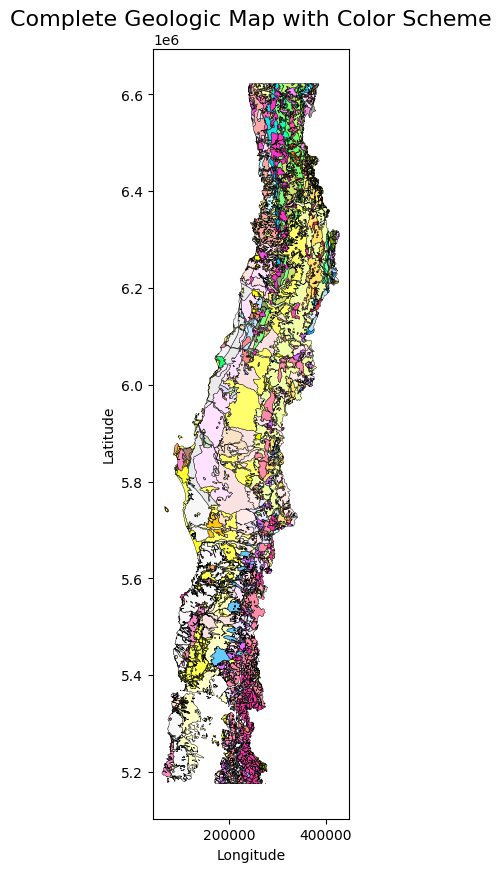


HOW TO USE IN QGIS:
METHOD 1 (Automatic - Easiest):
  - Simply drag 'geo_centro_colored.shp' into QGIS
  - The colors will load automatically!

METHOD 2 (Manual):
  1. Load the shapefile in QGIS
  2. Right-click layer → Properties → Symbology
  3. Click 'Style' button (bottom left) → Load Style
  4. Select 'geo_centro_colored.qml'

Total features: 4525
Unique geologic units in data: 93
Units with defined colors: 158

✓ All units in your data have colors defined!


In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Load the shapefile
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Create output directory
output_dir = "/Users/Glong1/Desktop/Andes/Geologic_Map/shapefiles"
os.makedirs(output_dir, exist_ok=True)

# Save the shapefile (no color column needed)
output_shapefile = os.path.join(output_dir, 'geo_centro_colored.shp')
gdf.to_file(output_shapefile)
print(f"Shapefile saved to: {output_shapefile}")

# CREATE THE QGIS QML STYLE FILE
# This is what makes QGIS automatically color your map
qml_path = os.path.join(output_dir, 'geo_centro_colored.qml')

# Start the QML file
qml_content = '''<!DOCTYPE qgis PUBLIC 'http://mrcc.com/qgis.dtd' 'SYSTEM'>
<qgis version="3.0.0">
  <renderer-v2 type="categorizedSymbol" attr="GEO" symbollevels="0" enableorderby="0">
    <categories>
'''

# Add each geologic unit
for unit, color in geologic_colors.items():
    # Only add units that have colors defined (not empty strings)
    if color and color != '':
        qml_content += f'''      <category render="true" symbol="{unit}" value="{unit}" label="{unit}"/>
'''

# Add default category for undefined units
qml_content += '''      <category render="true" symbol="default" value="" label="Other"/>
    </categories>
    <symbols>
'''

# Define the actual colors for each symbol
for unit, color in geologic_colors.items():
    if color and color != '':
        # Convert hex to RGB
        hex_color = color.lstrip('#')
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        
        qml_content += f'''      <symbol type="fill" name="{unit}" alpha="1">
        <layer class="SimpleFill">
          <prop k="color" v="{r},{g},{b},255"/>
          <prop k="outline_color" v="0,0,0,255"/>
          <prop k="outline_width" v="0.3"/>
        </layer>
      </symbol>
'''

# Add default symbol for undefined units
qml_content += '''      <symbol type="fill" name="default" alpha="1">
        <layer class="SimpleFill">
          <prop k="color" v="221,221,221,255"/>
          <prop k="outline_color" v="0,0,0,255"/>
          <prop k="outline_width" v="0.3"/>
        </layer>
      </symbol>
    </symbols>
  </renderer-v2>
</qgis>
'''

# Write the QML file
with open(qml_path, 'w') as f:
    f.write(qml_content)

print(f"\n✓ QGIS style file saved to: {qml_path}")

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each geologic unit with its color
for unit in gdf['GEO'].unique():
    if unit is not None:
        unit_data = gdf[gdf['GEO'] == unit]
        color = geologic_colors.get(unit, '#DDDDDD')
        # Only apply color if it's defined (not empty string)
        if not color or color == '':
            color = '#DDDDDD'
        unit_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, alpha=1.0)

plt.title('Complete Geologic Map with Color Scheme', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot
plot_path = os.path.join(output_dir, 'complete_geologic_map.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Map visualization saved to: {plot_path}")

plt.show()

# Print instructions
print("\n" + "="*70)
print("HOW TO USE IN QGIS:")
print("="*70)
print("METHOD 1 (Automatic - Easiest):")
print("  - Simply drag 'geo_centro_colored.shp' into QGIS")
print("  - The colors will load automatically!")
print("")
print("METHOD 2 (Manual):")
print("  1. Load the shapefile in QGIS")
print("  2. Right-click layer → Properties → Symbology")
print("  3. Click 'Style' button (bottom left) → Load Style")
print("  4. Select 'geo_centro_colored.qml'")
print("="*70)

# Print summary
print(f"\nTotal features: {len(gdf)}")
print(f"Unique geologic units in data: {gdf['GEO'].nunique()}")
print(f"Units with defined colors: {sum(1 for v in geologic_colors.values() if v and v != '')}")

# Show which units in your data don't have colors yet
units_in_data = set(gdf['GEO'].dropna().unique())
units_with_colors = set(k for k, v in geologic_colors.items() if v and v != '')
units_without_colors = units_in_data - units_with_colors

if units_without_colors:
    print(f"\n⚠ Units in your data WITHOUT colors (will show as gray):")
    for unit in sorted(units_without_colors):
        print(f"  - {unit}")
else:
    print("\n✓ All units in your data have colors defined!")